# Task 1:
### Do basic pre-processing

## Exploratory Data Analysis

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

Load loangrant.csv and display basic df information along with .head()

In [2]:
# Load the dataset
df = pd.read_csv("loangrant.csv")

# Display basic information about the dataset
df.info()

<ipython-input-2-435762939>:2: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loangrant.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111107 non-null  object 
 1   Customer ID                   111107 non-null  object 
 2   Loan Status                   111107 non-null  object 
 3   Current Loan Amount           111107 non-null  int64  
 4   Term                          111107 non-null  object 
 5   Credit Score                  89769 non-null   float64
 6   Years in current job          106414 non-null  object 
 7   Home Ownership                111107 non-null  object 
 8   Annual Income                 89769 non-null   float64
 9   Purpose                       111107 non-null  object 
 10  Monthly Debt                  111107 non-null  object 
 11  Years of Credit History       111107 non-null  float64
 12  Months since last delinquent  52104 non-null

Identifying total # of missing values per column

In [3]:
missing_values = df.isnull().sum() # for each column, count the total num of empty rows
missing_percentage = (missing_values / len(df)) * 100 # convert count into percentage
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}) # create a new df that stores missing value count and percentage for each field
missing_df[missing_df['Missing Values'] > 0] # show those fields whose missing value count > 0

,Missing Values,Percentage
Credit Score,21338,19.204911
Years in current job,4693,4.223856
Annual Income,21338,19.204911
Months since last delinquent,59003,53.104665
Bankruptcies,228,0.205208
Tax Liens,11,0.009900


Plotting a heatmap of missing values per column

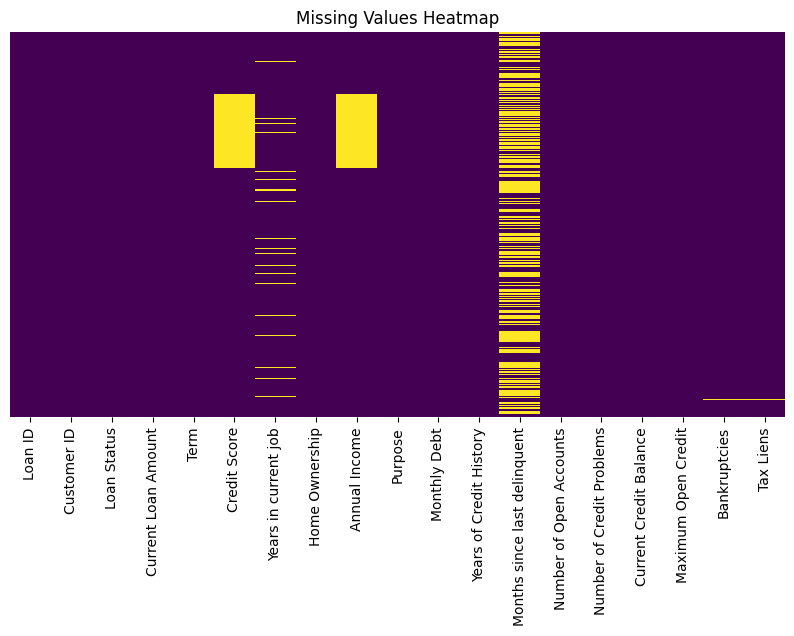

In [4]:
plt.figure(figsize=(10,5)) # define figure size
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False) # create a heatmap
plt.title("Missing Values Heatmap")
plt.show()

The above visualization shows that Credit Score, Years in Current Job, Annual Income, and Month since last delinquent have missing values.

Replacing missing values,

If numeric -> replace w/ median (except for "Months since last delinquent, in which case replace NA with 0)

If categorical -> replace w/ mode

In [5]:
numeric_columns = [
    "Current Loan Amount", "Credit Score", "Annual Income", "Monthly Debt",
    "Years of Credit History", "Months since last delinquent", "Number of Open Accounts",
    "Number of Credit Problems", "Current Credit Balance", "Maximum Open Credit",
    "Bankruptcies", "Tax Liens"
]

categorical_columns = ["Loan Status", "Term", "Home Ownership", "Years in current job", "Purpose"]

In [6]:
from sklearn.impute import SimpleImputer
import pandas as pd

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('object')

# Special handling for 'Months since last delinquent'
if "Months since last delinquent" in df.columns:
    df["Months since last delinquent"] = df["Months since last delinquent"].fillna(0)

num_cols_to_impute = [col for col in numeric_columns
                     if col in df.columns and col != "Months since last delinquent"]
if num_cols_to_impute:
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols_to_impute] = num_imputer.fit_transform(df[num_cols_to_impute])

# Impute categorical columns
cat_cols_to_impute = [col for col in categorical_columns if col in df.columns]
if cat_cols_to_impute:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols_to_impute] = cat_imputer.fit_transform(df[cat_cols_to_impute])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111107 non-null  object 
 1   Customer ID                   111107 non-null  object 
 2   Loan Status                   111107 non-null  object 
 3   Current Loan Amount           111107 non-null  float64
 4   Term                          111107 non-null  object 
 5   Credit Score                  111107 non-null  float64
 6   Years in current job          111107 non-null  object 
 7   Home Ownership                111107 non-null  object 
 8   Annual Income                 111107 non-null  float64
 9   Purpose                       111107 non-null  object 
 10  Monthly Debt                  111107 non-null  float64
 11  Years of Credit History       111107 non-null  float64
 12  Months since last delinquent  111107 non-nul

## Outlier Removal

Following code is for outlier detectiong via the IQR method. The outliers are replaced with the median values, since the median is resistant to outliers. The data is then plotted

In [7]:
outlier_counts = {}  # Store the percentage of outliers for each column

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df)) * 100
    outlier_counts[col] = round(outlier_percentage, 2)  # Store percentage

    # Replace outliers with the median
    median_value = df[col].median()
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])

The following shows basic statistics prior to outlier removal

In [8]:
print("Percentage of Outliers in Each Column (Before Removal):")
for col, pct in outlier_counts.items():
    print(f"{col}: {pct}%")

print("\nBasic Statistics After Outlier Removal:")

df.info()

Percentage of Outliers in Each Column (Before Removal):
Current Loan Amount: 11.46%
Credit Score: 10.28%
Annual Income: 6.89%
Monthly Debt: 3.4%
Years of Credit History: 3.09%
Months since last delinquent: 2.09%
Number of Open Accounts: 2.27%
Number of Credit Problems: 13.92%
Current Credit Balance: 5.18%
Maximum Open Credit: 5.73%
Bankruptcies: 11.01%
Tax Liens: 1.92%

Basic Statistics After Outlier Removal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111107 non-null  object 
 1   Customer ID                   111107 non-null  object 
 2   Loan Status                   111107 non-null  object 
 3   Current Loan Amount           111107 non-null  float64
 4   Term                          111107 non-null  object 
 5   Credit Score                  111107 non-null  floa

Check to see if there are any missing values due to coerce

## Repeat Instance Removal

The following code checks to see if there are any repeat instances in any of the columns, counts and displays them

In [9]:
num_duplicate_rows = df.duplicated().sum()

# Get the actual duplicated rows (all duplicates including the first)
duplicate_instances = df[df.duplicated(keep=False)]

# Optional: See how many times each duplicated instance occurs
repeat_instances_counts = duplicate_instances.value_counts()

print(f"Number of duplicated rows: {num_duplicate_rows}")
print("\nRepeated instances and their counts:\n")
print(repeat_instances_counts)

Number of duplicated rows: 12594

Repeated instances and their counts:

Loan ID                               Customer ID                           Loan Status  Current Loan Amount  Term        Credit Score  Years in current job  Home Ownership  Annual Income  Purpose             Monthly Debt  Years of Credit History  Months since last delinquent  Number of Open Accounts  Number of Credit Problems  Current Credit Balance  Maximum Open Credit  Bankruptcies  Tax Liens
ffffe32e-ed17-459f-9cfd-7b9ee7972933  97281336-1e45-41d2-acb2-263ce56a590e  Fully Paid   27902.0              Long Term   678.0         10+ years             Home Mortgage   117480.0       Debt Consolidation  852.72        18.0                     11.0                          10.0                     0.0                        28317.0                 62371.0              0.0           0.0          2
000582b2-2b2e-4290-9360-43e3a93b57c2  bafabc36-a32f-489c-9531-896ff66c9171  Fully Paid   16080.0              Long Term   692

Removing duplicate instances, as this can negatively impact model training and may lead to overfitting

In [10]:
# Drop duplicates and keep the first occurrence
df_unique = df.drop_duplicates(keep='first').reset_index(drop=True)

# Optional: check how many rows were dropped
num_dropped = len(df) - len(df_unique)
print(f"Number of duplicate rows removed: {num_dropped}")

df_default = df_unique.copy()

df_default.info()

Number of duplicate rows removed: 12594
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98513 entries, 0 to 98512
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       98513 non-null  object 
 1   Customer ID                   98513 non-null  object 
 2   Loan Status                   98513 non-null  object 
 3   Current Loan Amount           98513 non-null  float64
 4   Term                          98513 non-null  object 
 5   Credit Score                  98513 non-null  float64
 6   Years in current job          98513 non-null  object 
 7   Home Ownership                98513 non-null  object 
 8   Annual Income                 98513 non-null  float64
 9   Purpose                       98513 non-null  object 
 10  Monthly Debt                  98513 non-null  float64
 11  Years of Credit History       98513 non-null  float64
 12  Months since last de

### Task 2:

Classification w/ Decision Tree, Bagging, Boosting, Random Forest, KNN, SVM

**NOTE:** We will be using "Loan Status" as the target feature

In [11]:
# check if dataset is balanced
df["Loan Status"].value_counts()

,count
Loan Status,
Fully Paid,85934
Charged Off,25173


As can be seen above, the dataset is heavily unbalanced in favor of "Fully Paid".


With this in mind, we will first proceed with classification with the dataset as is, without modifications.

We will ignore the Customer ID and Loan ID columns, and use Loan Status as our output/label

In [12]:
df_preprocessed = df.drop(columns=["Customer ID", "Loan ID"])
df_preprocessed.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Charged Off,12232.0,Short Term,724.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12.0,0.0,6762.0,7946.0,0.0,0.0
1,Charged Off,25014.0,Long Term,724.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,0.0,14.0,0.0,35706.0,21243.0,0.0,0.0
2,Charged Off,16117.0,Short Term,724.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11.0,0.0,11275.0,14815.0,0.0,0.0
3,Charged Off,11716.0,Short Term,724.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,0.0,21.0,0.0,7009.0,43533.0,0.0,0.0
4,Charged Off,9789.0,Long Term,724.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13.0,0.0,16913.0,19553.0,0.0,0.0


Importing libraries for making a train-test split

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Converting target labels to binary

In [14]:
# Define columns
numeric_columns = [
    "Current Loan Amount", "Credit Score", "Annual Income", "Monthly Debt",
    "Years of Credit History", "Months since last delinquent", "Number of Open Accounts",
    "Number of Credit Problems", "Current Credit Balance", "Maximum Open Credit",
    "Bankruptcies", "Tax Liens"
]

categorical_columns = ["Term", "Home Ownership", "Years in current job", "Purpose"]

df.drop(columns = ["Loan ID", "Customer ID"]) # removing irrelevant columns

X = df.drop(columns=["Loan Status"])
y = df["Loan Status"]

y = y.map({"Charged Off": 0, "Fully Paid": 1})

y.value_counts()

,count
Loan Status,
1,85934
0,25173


Further pre-processing (in case anything got missed)

In [15]:
# Numeric preprocessing: impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: impute missing and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine both into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('obj', categorical_transformer, categorical_columns)
])

Making a train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Defining classifiers to be used (not doing class_balance for now)

In [17]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Bagging": BaggingClassifier(LogisticRegression(random_state=42, solver='liblinear'), random_state=42), # Using logisticRegression, as by default BaggingClassifier uses DecisionTrees which would overlap w/ Random Forest
    "Boosting": AdaBoostClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(kernel='linear', max_iter=5000, probability=True, random_state=42)
}

Calculating and storing metrics

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


           Model  Accuracy  Sensitivity  Specificity    MCC    AUC
0  Decision Tree     0.740        0.844        0.384  0.235  0.614
1        Bagging     0.774        1.000        0.003  0.038  0.611
2       Boosting     0.777        0.990        0.048  0.118  0.725
3  Random Forest     0.798        0.983        0.165  0.283  0.801
4            KNN     0.749        0.919        0.171  0.124  0.596
5            SVM     0.674        0.811        0.206  0.018  0.512


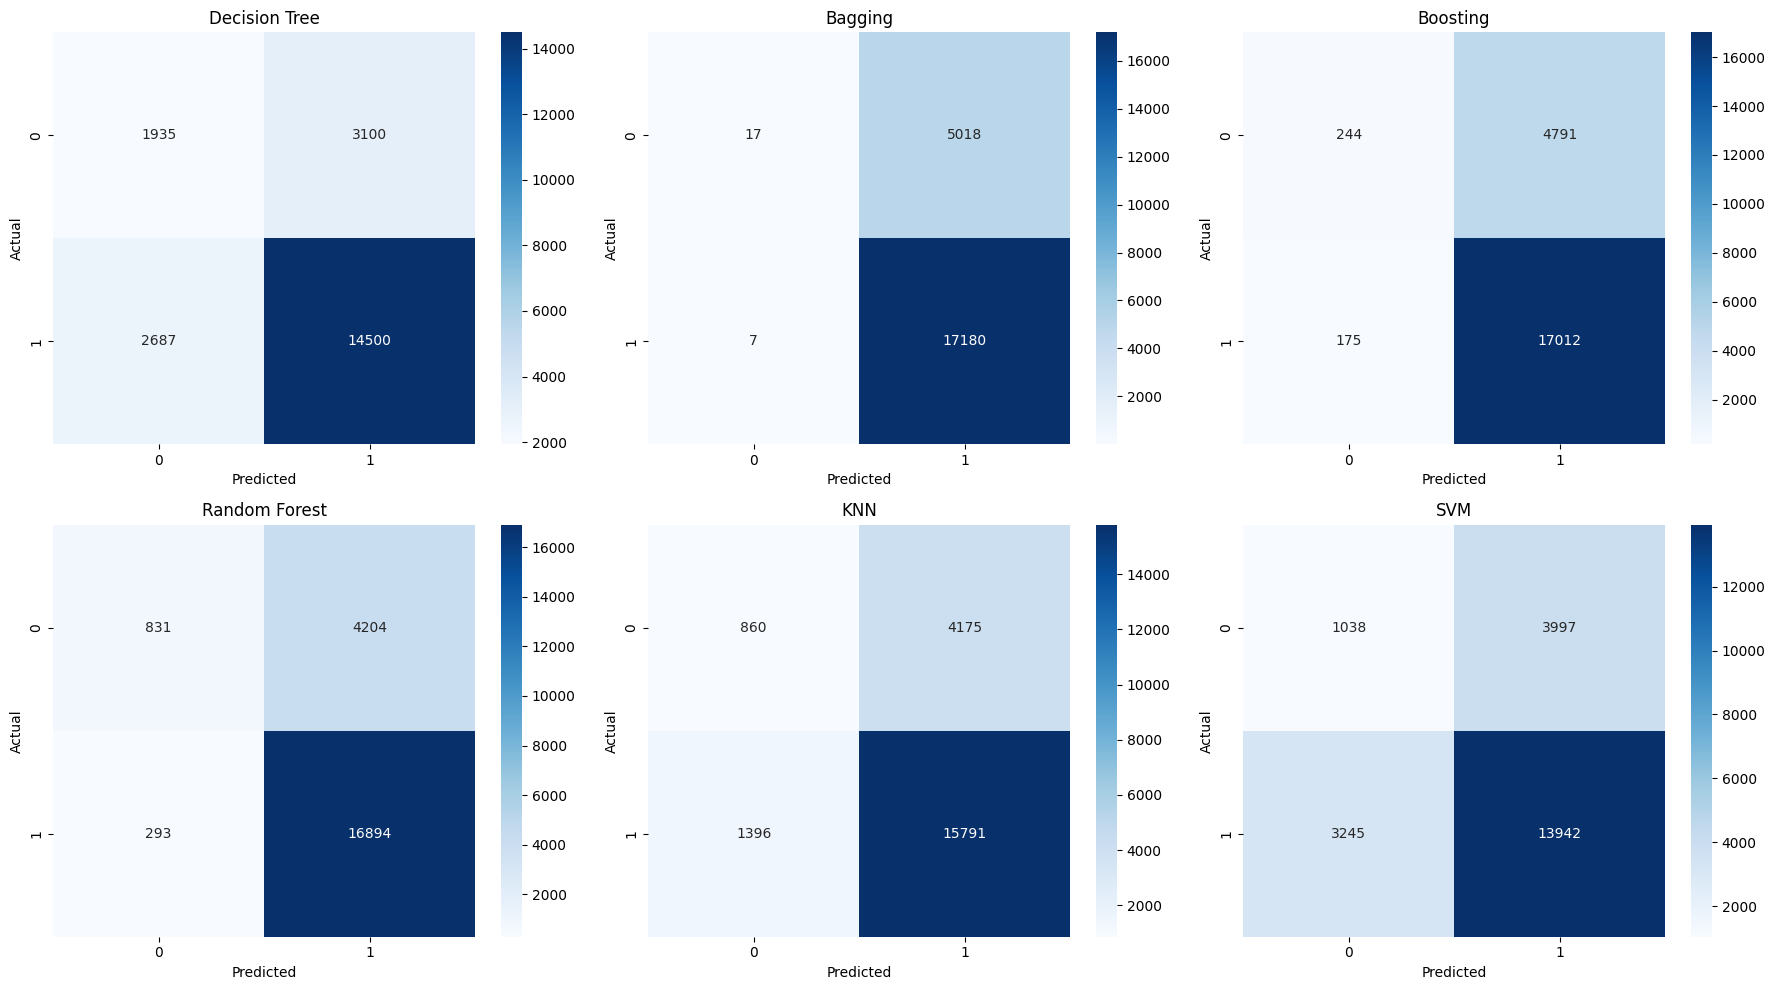

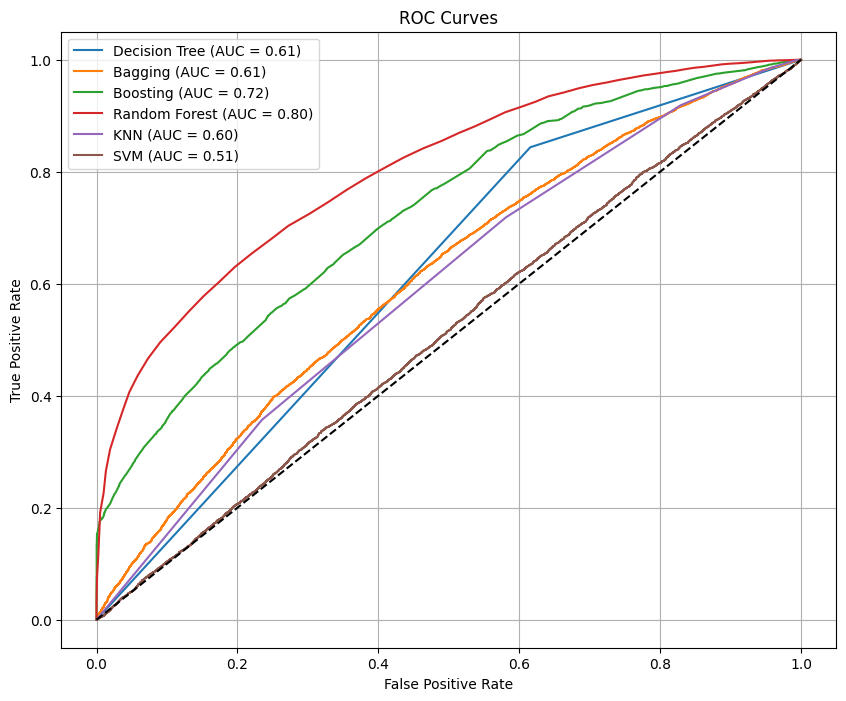

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score,
                           roc_curve, roc_auc_score, matthews_corrcoef)
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import gridspec


# Storage
results = []
conf_matrices = {}
roc_curves = {}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred)
    spec = tn / (tn + fp)
    mcc = matthews_corrcoef(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    conf_matrices[name] = cm
    roc_curves[name] = (fpr, tpr)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "MCC": mcc,
        "AUC": auc_score
    })

# Metrics table
results_df = pd.DataFrame(results).round(3)
print(results_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, (name, cm) in zip(axes.flatten(), conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, models[name].predict_proba(X_test_processed)[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.show()

### Extra:

This is an attempt to use the in-built sklearn parameters for their algorithms to deal with an imbalanced dataset

In [ ]:
models_balanced = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Bagging": BaggingClassifier(LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'), random_state=42), # Using logisticRegression, as by default BaggingClassifier uses DecisionTrees which would overlap w/ Random Forest
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "KNN": KNeighborsClassifier(metric = 'euclidean', weights='distance'),
    "SVM": SVC(kernel='linear', max_iter=3000, probability=True, random_state=42, class_weight='balanced')
}

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


           Model  Accuracy  Sensitivity  Specificity    MCC    AUC
0  Decision Tree     0.743        0.852        0.373  0.236  0.612
1        Bagging     0.588        0.596        0.561  0.132  0.611
2  Random Forest     0.794        0.986        0.139  0.261  0.799
3            KNN     0.765        0.939        0.172  0.166  0.669
4            SVM     0.488        0.464        0.572  0.030  0.520


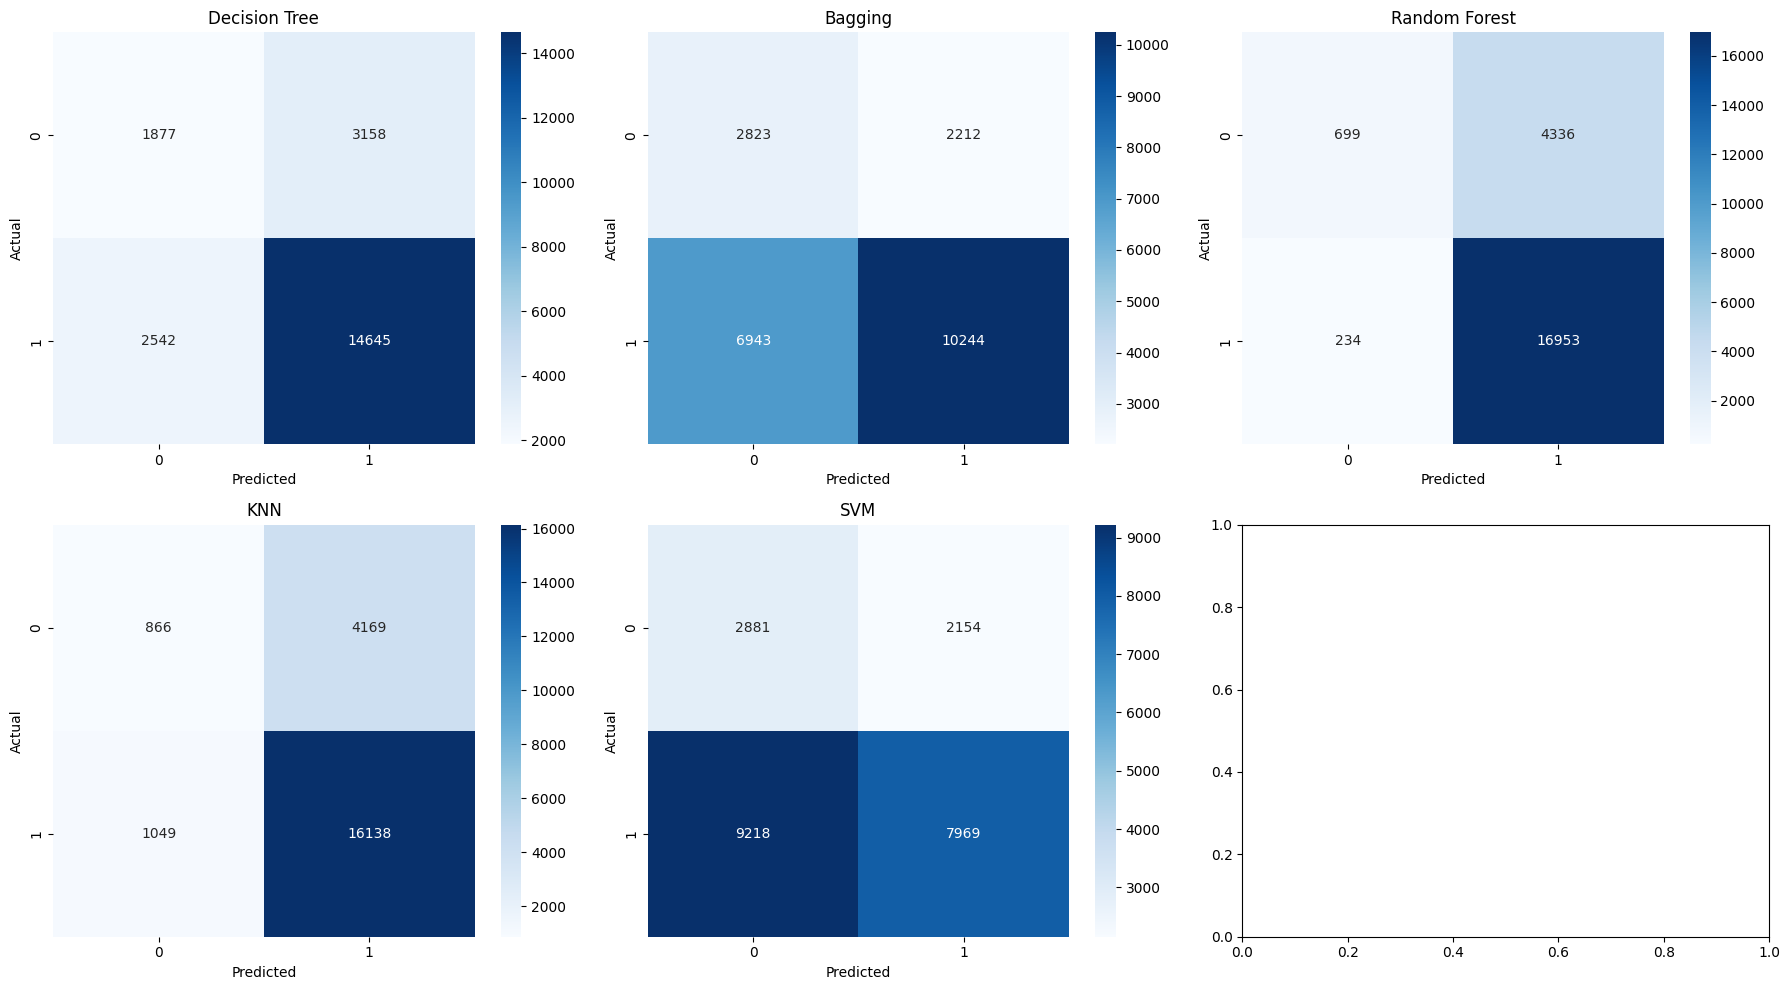

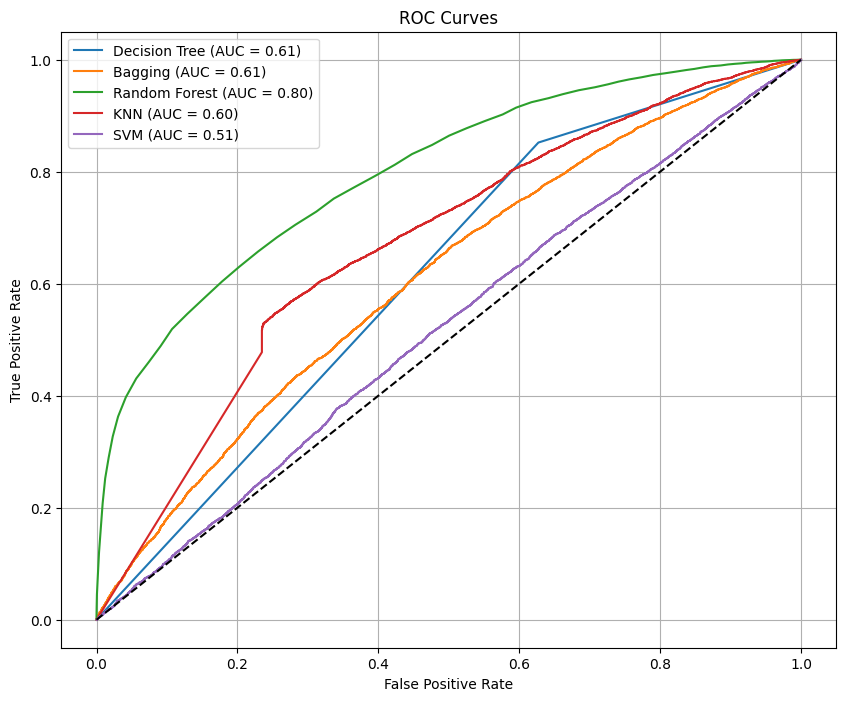

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score,
                           roc_curve, roc_auc_score, matthews_corrcoef)
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import gridspec


# Storage
results = []
conf_matrices = {}
roc_curves = {}

# Train and evaluate
for name, model in models_balanced.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred)
    spec = tn / (tn + fp)
    mcc = matthews_corrcoef(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    conf_matrices[name] = cm
    roc_curves[name] = (fpr, tpr)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "MCC": mcc,
        "AUC": auc_score
    })

# Metrics table
results_df = pd.DataFrame(results).round(3)
print(results_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, (name, cm) in zip(axes.flatten(), conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, models[name].predict_proba(X_test_processed)[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.show()